# Deep Q Network algorithm used to solve OpenAI gym task
In this notebook I have implemented my DQN agent to solve cartpole problem. Results obtained after training are rather poor but the main point was to learn idea of this architecture. I think this exercise was a great lesson, I understood deeply how this algorithm works and learned all optimizations used in it.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import pickle
from collections import deque
import random

2023-05-21 20:17:38.134016: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 20:17:38.315175: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 20:17:38.316218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 20:17:39.796512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Investigating environment
Let's start by running environment with graphical display and taking some random actions in it. Next we check how action and observation space looks like.

In [2]:
env = gym.make('CartPole-v1', render_mode='human')
observation, info = env.reset()
for _ in range(500):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()
env.close()

In [3]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
observation, info = env.reset()
observation

array([ 0.03484626,  0.03265911,  0.01581742, -0.03918906], dtype=float32)

In [4]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [5]:
env.action_space.sample()

0

In [6]:
env.action_space

Discrete(2)

In [7]:
env.close()

#### Network
At first I implemented 2 classes - DQN ineriting from tf.keras.Model that is just simple architecture used later for both my networks, and ReplayBuffer in which agent will store expiriences.

In [8]:
class DQN(tf.keras.Model):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.num_actions = num_actions
        self.layer1 = tf.keras.layers.Dense(100, activation="relu")
        self.layer2 = tf.keras.layers.Dense(50, activation="relu")
        self.layer3 = tf.keras.layers.Dense(num_actions, activation=None)
        
    def call(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.layer3(x)
    
    def get_config(self):
        return {"num_actions": self.num_actions}

In [9]:
class ReplayBuffer():
    def __init__(self, size):
        self.memory = deque(maxlen=size)
        
    def add(self, transition):
        self.memory.append(transition)
        
    def getBatch(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

#### Agent
Now it's time to build DQN agent. It has 2 neural networks - policy_net and target_net used to predict Q values in the future. Get action method is similar as in Q learning agent - it takes random action or trained action from policy net with probability based on epsilon. Then optimize method is responsible for training policy network - it's implementation of main formula of DQN. And also worth mentioning is soft update that takes target net a bit closer to policy net every step.

In [10]:
class DQNAgent:
    def __init__(self, num_actions, num_observations, learning_rate=0.001, batch_size=128, tau=0.005, buffer_size = 20_000,
                 epsilon=0.7, epsilon_decay=0.0001, final_epsilon=0.1, discount_factor=0.9):
        self.lr = learning_rate
        self.batch_size = batch_size
        self.tau = tau
        
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.policy_net = DQN(num_actions)
        self.target_net = DQN(num_actions)
        self.replay_buffer = ReplayBuffer(buffer_size)
        
        self.policy_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr, clipvalue=0.5), loss='mse')
        self.target_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr, clipvalue=0.5), loss='mse')
        
        self.policy_net.build((1,num_observations[0]))
        self.target_net.build((1,num_observations[0]))
        
    def get_action(self, obs):
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            x = self.policy_net(obs)
            return int(tf.argmax(x[0]))
    
    def optimize(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        transitions = self.replay_buffer.getBatch(self.batch_size)
        states, actions, next_states, rewards, dones = zip(*transitions)
        target = rewards + self.discount_factor*np.array(dones)* tf.math.reduce_max(self.target_net(tf.convert_to_tensor(next_states, dtype=tf.float32)), axis=1)
        target = tf.reshape(target,(len(target),1))
        states = tf.squeeze(tf.convert_to_tensor(states),axis=1)
        history = self.policy_net.fit(states,target, epochs=32, batch_size=self.batch_size, verbose=0)
        return history.history["loss"]
        
    def soft_update(self):
        policy_weights = self.policy_net.get_weights()
        target_weights = self.target_net.get_weights()
        updated_weights = []
        for i in range(len(policy_weights)):
            updated_weights.append(self.tau*policy_weights[i] + (1-self.tau)*target_weights[i])
        self.target_net.set_weights(updated_weights)
        
    def observe(self, state, action, next_state, reward, done):
        transition = (state, action, next_state, reward, done)
        self.replay_buffer.add(transition)
        
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
        
    def save(self, path):
        self.target_net.save('target_network')
        self.policy_net.save('policy_network')
            
    def load(self, path):
        self.target_net = tf.keras.load_model('target_network')
        self.policy_net = tf.keras.load_model('policy_network')

#### Training
Setting hyperparameters and training. I wasn't able to tune them to get good results in reasonable time however there definitely is some progress. Training loop is similar to other RL trainings. I'm optimizing model and soft updating target net once per epizode. After training I have prepared simple average duration plot.

In [11]:
env = gym.make('CartPole-v1')
observation_space = env.observation_space.shape
action_space = env.action_space.n

n_episodes = 2_000
start_eps = 0.9
final_eps = 0.1

lr = 0.0001
batch_size = 64
discount_factor = 0.99
tau = 0.01
eps_dec = (start_eps-final_eps)/(n_episodes*0.8)
agent = DQNAgent(action_space, observation_space, learning_rate=lr, batch_size = batch_size, tau=tau,
                 epsilon=start_eps, epsilon_decay=eps_dec, final_epsilon=final_eps, discount_factor=discount_factor)


In [12]:
losses = []
duration = []
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    obs = tf.reshape(tf.convert_to_tensor(obs, dtype=tf.float32), shape=(1,observation_space[0]))
    done = False
    ep_len = 0
    ep_rew = 0
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.observe(obs, action, next_obs, reward, 1 - int(done))

        
        obs = next_obs
        obs = tf.reshape(tf.convert_to_tensor(obs, dtype=tf.float32), shape=(1,observation_space[0]))
        ep_len+=1
        
    losses.append(agent.optimize())
    agent.soft_update()
    agent.decay_epsilon()
    duration.append(ep_len)
    

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [14:12<00:00,  2.35it/s]


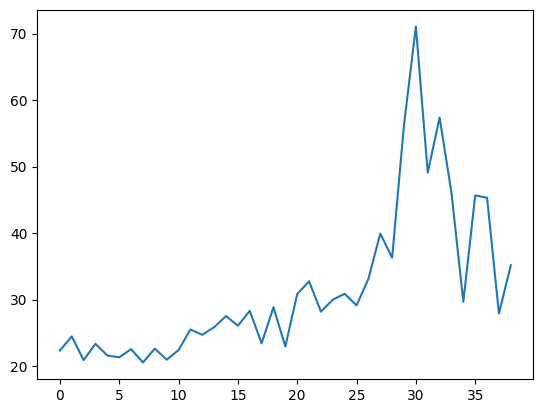

In [13]:
losses = [i for i in losses if i!=None]
avg_range = 50
avg_dur = [np.mean(duration[i:i+avg_range]) for i in range(0,len(duration)-avg_range,avg_range)]
# avg_loss = [np.mean(losses[i:i+avg_range]) for i in range(0,len(losses)-avg_range,avg_range)]
plt.plot(avg_dur)
# plt.plot(avg_loss)

#### Evaluation
Now let's save the model and check if it is really better than random. 

In [14]:
agent.save('')

INFO:tensorflow:Assets written to: target_network/assets


INFO:tensorflow:Assets written to: target_network/assets


INFO:tensorflow:Assets written to: policy_network/assets


INFO:tensorflow:Assets written to: policy_network/assets


In [15]:
env = gym.make('CartPole-v1', render_mode="human")
for episode in tqdm(range(5)):
    obs, info = env.reset()
    obs = tf.reshape(tf.convert_to_tensor(obs, dtype=tf.float32), shape=(1,observation_space[0]))
    done = False
    

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.observe(obs, action, next_obs, reward, 1-int(done))

        done = terminated or truncated
        obs = next_obs
        obs = tf.reshape(tf.convert_to_tensor(obs, dtype=tf.float32), shape=(1,observation_space[0]))

env.close()

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


In [37]:
env.close()